# Import

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TXT/Consumer_Complaints.csv', engine='python', encoding='utf-8', error_bad_lines=False, sep=',')
data.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer Complaint', 'Company Public Response', 'Company', 'State',
       'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via',
       'Date Sent to Company', 'Company Response to Consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID',
       'Unnamed: 18'],
      dtype='object')

In [ ]:
data = data[["Product","Consumer Complaint"]]

In [ ]:
data.head()

,Product,Consumer Complaint
0,Mortgage,NaN
1,Credit reporting,I have outdated information on my credit repor...
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...
3,Credit card,NaN
4,Debt collection,NaN


In [ ]:
data.Product.value_counts()

Mortgage                                                                        254165
Debt collection                                                                 196212
Credit reporting                                                                140433
Credit reporting, credit repair services, or other personal consumer reports    110756
Credit card                                                                      89191
Bank account or service                                                          86206
Student loan                                                                     42969
Consumer Loan                                                                    31606
Credit card or prepaid card                                                      22913
Checking or savings account                                                      18982
Money transfer, virtual currency, or money service                                5785
Vehicle loan or lease                      

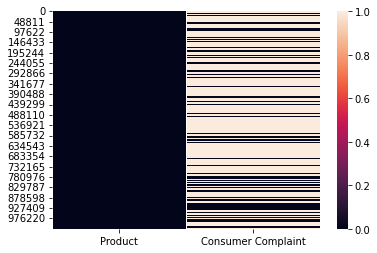

In [ ]:
sns.heatmap(data.isnull())

# Preprocessing & Vizz

In [ ]:
# We will group some product types 
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'


In [ ]:
# In the code below you should add : Prepaid card, Consumer Loan & Bank account or service to "Other financial service"
data.loc[data['Product'] == 'Prepaid card', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Consumer Loan', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Bank account or service', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Money transfers', 'Product'] = 'Money transfer, virtual currency, or money service'
# CODE HERE

# We will not consider other financial service
# Code Here
data = data[data.Product != 'Other financial service']

In [ ]:
data = data.reset_index(drop=True)
data.Product.value_counts()


Mortgage                                                                        254165
Credit reporting, credit repair services, or other personal consumer reports    251189
Debt collection                                                                 196212
Credit card or prepaid card                                                     112104
Student loan                                                                     42969
Checking or savings account                                                      18982
Money transfer, virtual currency, or money service                               11157
Payday loan, title loan, or personal loan                                         9913
Vehicle loan or lease                                                             5628
Name: Product, dtype: int64

In [ ]:
data

,Product,Consumer Complaint
0,Mortgage,NaN
1,"Credit reporting, credit repair services, or o...",I have outdated information on my credit repor...
2,Credit card or prepaid card,NaN
3,Debt collection,NaN
4,Mortgage,NaN
...,...,...
902314,Debt collection,NaN
902315,Debt collection,I had an account with XXXX in XX/XX/XXXX this ...
902316,Mortgage,I was contacted on XX/XX/XXXX email by XXXX fr...
902317,Debt collection,NaN


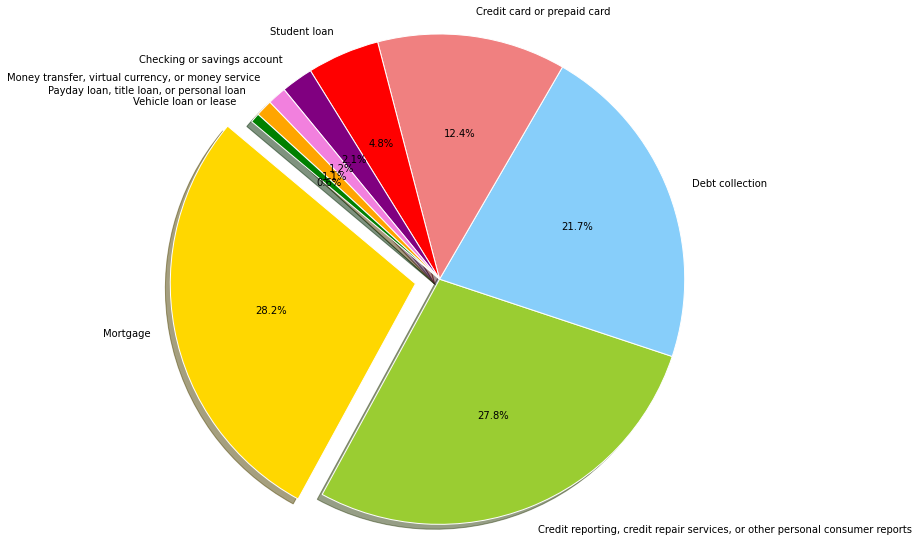

In [ ]:
# Data to plot
labels = list(data.Product.value_counts().index)
sizes = list(data.Product.value_counts().values)
colors = ['gold','yellowgreen', 'lightskyblue', 'lightcoral', 'red', 'purple', '#f280de', 'orange', 'green']
explode = (0.1, 0, 0, 0,0,0,0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, wedgeprops={"edgecolor":"white"})
plt.axis('equal')
plt.show()

In [ ]:
def complaint_product(indx,data):
  complaint = data['Consumer Complaint'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [ ]:
complaint_product(238, data)

XXXX XXXX policy was switched after an the quote they gave me was incorrect and suddently increase my price. The month of insurance with XXXX XXXX was paid and yet XXXX XXXX kept billing for months when XXXX sent them notice and took over our auto policy. 

The collection firm nor XXXX XXXX XXXX sent a notice of debt or collection. We never received a phone call or letter after the cancellation of account.
------------------------------
Product :  Debt collection


In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    if (type(text)!=float) :
      text = text.lower()
      text = re.sub('\[.*?\]', '', text)
      text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
      text = re.sub('\w*\d\w*', '', text)
      text = re.sub('\n', '', text)
      text = text.replace('x', '')
      text = ' '.join(word for word in text.split() if word not in STOPWORDS)
      return text

In [ ]:
# Code Here
data['Consumer Complaint'] = data['Consumer Complaint'].apply(clean_text) # apply clean_text function 

In [ ]:
data

,Product,Consumer Complaint
0,Mortgage,None
1,"Credit reporting, credit repair services, or o...",outdated information credit report previously ...
2,Credit card or prepaid card,None
3,Debt collection,None
4,Mortgage,None
...,...,...
902314,Debt collection,None
902315,Debt collection,account previously disputed sold towers area e...
902316,Mortgage,contacted email caliber home loans refinance c...
902317,Debt collection,None


In [ ]:
# After cleaning
complaint_product(238, data)

policy switched quote gave incorrect suddently increase price month insurance paid yet kept billing months sent notice took auto policy collection firm sent notice debt collection never received phone call letter cancellation account
------------------------------
Product :  Debt collection


In [ ]:
data["Consumer Complaint"].fillna('text', inplace = True)
text = " ".join(complaint for complaint in data["Consumer Complaint"])


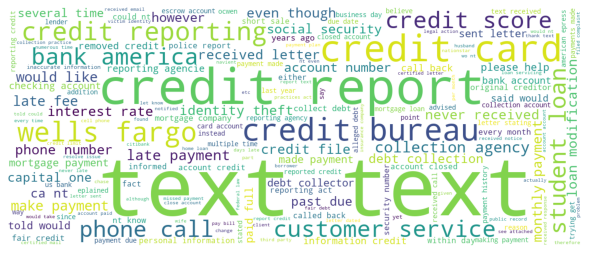

In [ ]:
text = " ".join(Complaint for Complaint in data["Consumer Complaint"])
# Generate a word cloud image

wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = 'white') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer Complaint"]]

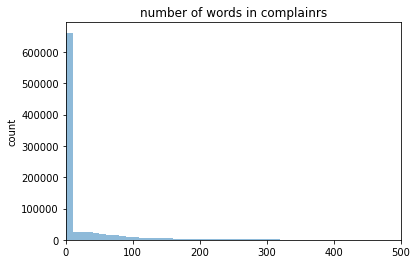

In [ ]:
# fixed bin size
bins = np.arange(-0, 3000, 10) # fixed bin size

plt.xlim([0, 500])

plt.hist(number_words, bins=bins, alpha=0.5)
plt.title('number of words in complainrs')
plt.ylabel('count')

plt.show()

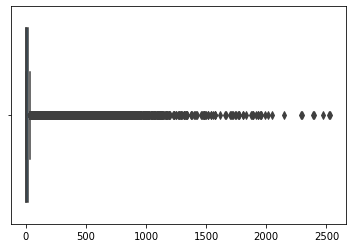

In [ ]:
sns.boxplot(number_words)

# Multi-Class Text Classification LSTM 

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer Complaint'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 125926 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(data['Consumer Complaint'].values)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

Shape of data tensor: (902319, 250)


In [ ]:
labels = list(pd.get_dummies(data['Product']).columns)
Y = pd.get_dummies(data['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (902319, 9)


In [ ]:
# Code Here
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(721855, 250) (721855, 9)
(180464, 250) (180464, 9)


**Expected Output :**
(35449, 250) (35449, 9)
(8863, 250) (8863, 9)

In [ ]:
# Code Here
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=None))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 9)                 909       
                                                                 
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param   
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909    
_________________________________________________________________

Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0


In [ ]:
epochs = 5
batch_size = 64
# Code Here
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [ ]:
# evaluate model on test set
# Code Here
score = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

Test set

  Loss: 0.66
  
  Accuracy: 0.80

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [ ]:
# Code Here
expected_classes = np.argmax(Y_test, axis=1)

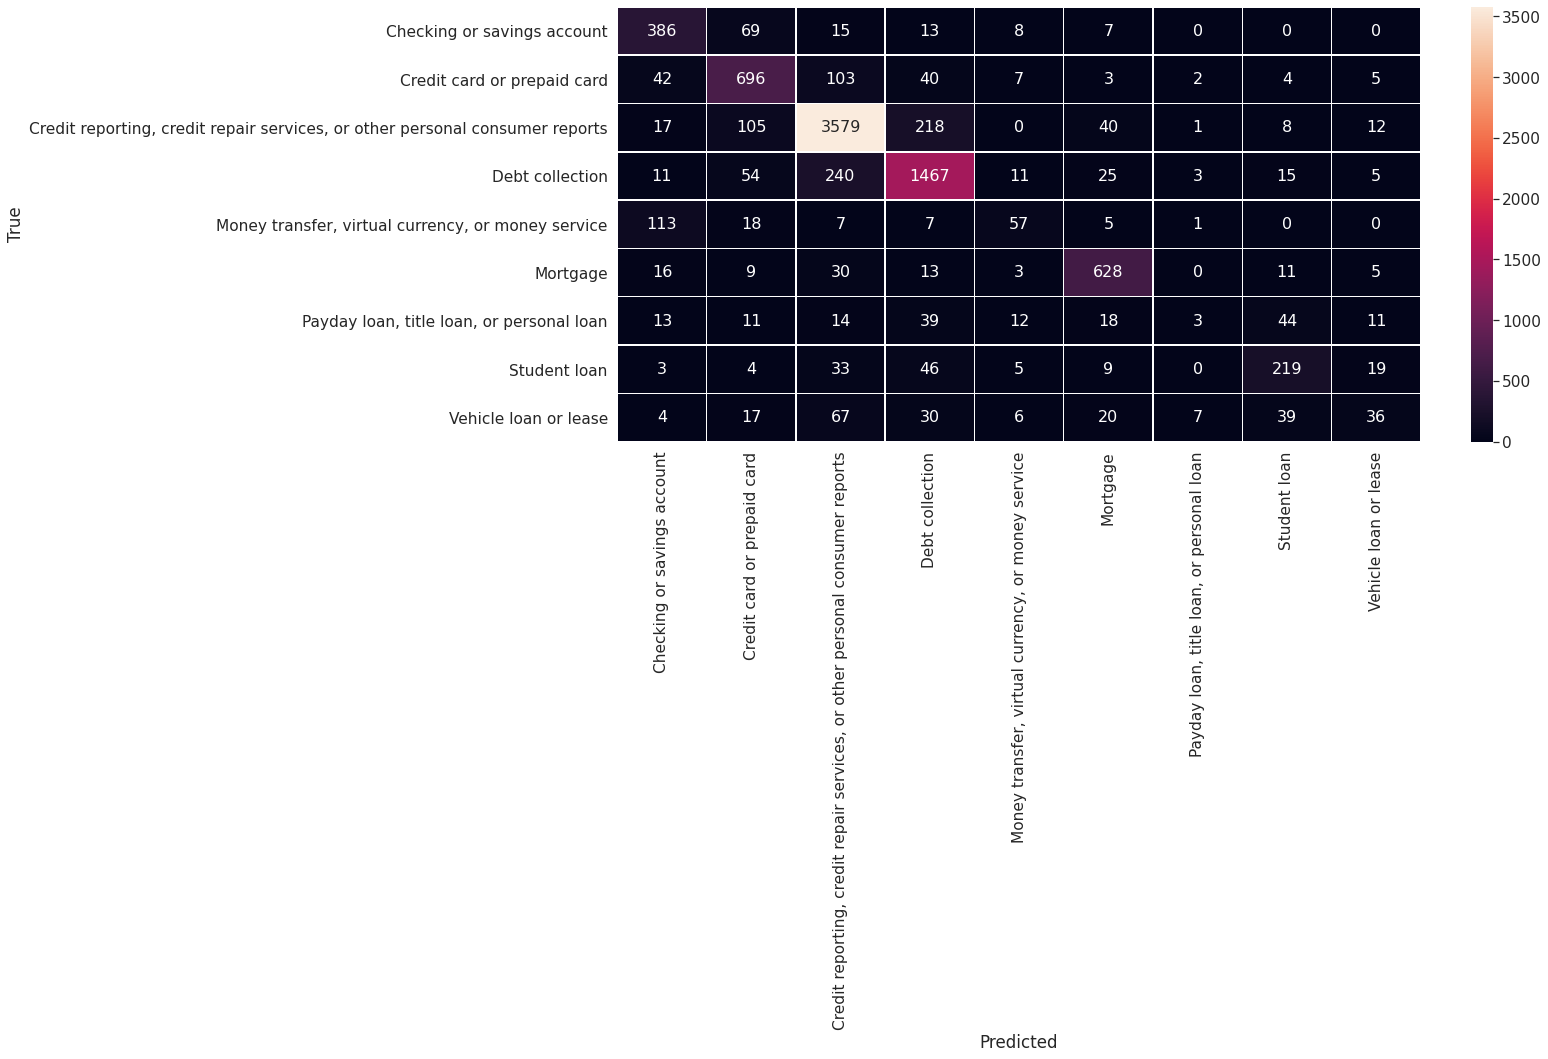

In [ ]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()